# Problem statement: 
* The data has 10,000,000 rows and 10 variables.
* Dataset is imbalanced: 596014 Fraud vs. 9403986 non-Fraud. 
* This is a binary classification problem. The classification goal is to detect fraud credit cards.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the missing values, etc.)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicated values, etc. 
- Basic data exploration
- Preparing data for Machine Learning:
    - One-hot-encoding of categorical features
    - Vector Assembling
    - Splitting data into training & test parts (I use the training part for training & hyperparameter tuning of models, test part for the final evaluation of models)
    
 # Model Training: 
- I separately train following models:
     - Logistic Regression (LR)
     - Random Forest (RF)
     - Gradient Boosting Trees (GBTs)
     
 Note: I use Grid-Search technique to find optimal hyper-parameters of each model. Also, I undersample the majority class to even the imbalances. 

  # Model Evaluation: 
- I separately evaluate the best LR, RF and GBT models, by calculating/plotting following mertics on Test dataset:
     - roc_auc score
     - f1 score
     - Confusion matrix
     - ROC curve  
     - Average precision
 
 
- Calculating the Feature Importance with RF and GBTs models.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import findspark 
findspark.init('/home/rhashemee/spark-2.1.0-bin-hadoop2.7')

import pyspark

import sklearn
import numpy as np
from scipy import stats
import pandas as pd
import imblearn as im
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]")\
                            .appName("CCFraud")\
                            .enableHiveSupport()\
                            .getOrCreate()

#spark.conf.set('spark.driver.memory','8g')
#spark.conf.set('spark.executor.memory', '8g')
#spark.conf.set('spark.executor.cores', '6')
#spark.conf.set('spark.cores.max', '6')

sc = spark.sparkContext

In [3]:
sc.getConf().getAll()

[('spark.app.id', 'local-1535086048806'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('hive.metastore.warehouse.dir',
  'file:/home/rhashemee/Documents/Spark%20projects/CCFraud/spark-warehouse'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '39631'),
 ('spark.app.name', 'CCFraud'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '10.0.2.15')]

In [4]:
# To create a new configuration and use that to create a SparkContext.
#conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','8g')])
#sc.stop()
#sc = pyspark.SparkContext(conf=conf)

In [5]:
# Approach 1: We import dataset directly as a Data Frame
fraud_df1=spark.read.csv('ccFraud.csv', header=True, inferSchema=True)

In [6]:
# fraud_df1 = fraud_df1.repartition(6)

In [7]:
fraud_df1.show(1)

+------+------+-----+----------+-------+--------+------------+----------+---------+
|custID|gender|state|cardholder|balance|numTrans|numIntlTrans|creditLine|fraudRisk|
+------+------+-----+----------+-------+--------+------------+----------+---------+
|     1|     1|   35|         1|   3000|       4|          14|         2|        0|
+------+------+-----+----------+-------+--------+------------+----------+---------+
only showing top 1 row



In [8]:
fraud_df1.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [9]:
# Approach 2: We import dataset initially as a RDD. After some transfomations/actions we convert it to Data Frame
fraud_rdd = sc.textFile('ccFraud.csv')

In [10]:
fraud_rdd.take(3)

['"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"',
 '1,1,35,1,3000,4,14,2,0',
 '2,2,2,1,0,9,0,18,0']

In [11]:
header = fraud_rdd.first()
fraud_rdd = fraud_rdd.filter(lambda row: row != header)\
        .map(lambda row: [int(elem) for elem in row.split(',')])

In [12]:
# Create schema for DataFrame:
from pyspark.sql import types

fields = [*[types.StructField(i[1:-1], types.IntegerType(), True)   for i in header.split(',')]]

schema = types.StructType(fields)
print(schema)

StructType(List(StructField(custID,IntegerType,true),StructField(gender,IntegerType,true),StructField(state,IntegerType,true),StructField(cardholder,IntegerType,true),StructField(balance,IntegerType,true),StructField(numTrans,IntegerType,true),StructField(numIntlTrans,IntegerType,true),StructField(creditLine,IntegerType,true),StructField(fraudRisk,IntegerType,true)))


In [14]:
# Convert RDD to spark DataFrame:
fraud_df2 = spark.createDataFrame(fraud_rdd, schema)

In [15]:
fraud_df2.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [16]:
# helpful function to detect the Missing Values:
def detect_missing(df):
    import pyspark.sql.functions as fn
    miss_count=df.agg(*[(fn.count('*')-fn.count(c)).alias(c)   for c in df.columns]).toPandas()
    miss_percent=df.agg(*[(1-(fn.count(c)/fn.count('*'))).alias(c)   for c in df.columns]).toPandas()
    
    summary = pd.concat([miss_count, miss_percent], axis=0)
    summary['  '] = ['Count of miss values: ', 'Percentage of miss values: ']
    summary.set_index('  ', inplace=True)
    return summary

# helpful function to detect the Duplicate Values:
def detect_duplicates(df):
    print('Count of rows: ', df.count())
    print('Count of distinct rows: ', df.distinct().count())

In [17]:
# Check for Duplicates: 
detect_duplicates(fraud_df1)

# df.dropDuplicates() # Drop duplicate values

Count of rows:  10000000
Count of distinct rows:  10000000


In [18]:
# Dataset is Imbalanced:
fraud_df1.groupBy('fraudRisk').count().show()

+---------+-------+
|fraudRisk|  count|
+---------+-------+
|        1| 596014|
|        0|9403986|
+---------+-------+



In [19]:
detect_missing(fraud_df1)

,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
,,,,,,,,,
Count of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preparing Data for Machine Learning:

In [20]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# One-Hot-Encoding of Categorical features:
categoricalColumns = ['gender', 'state', 'cardholder']     # specify nominal categorical features
ordinalColumns = [ ]        # specify ordinal categorical features


stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "_classVec")
    stages += [stringIndexer, encoder]

    
label_stringIdx = StringIndexer(inputCol = 'fraudRisk', outputCol = 'label')
stages += [label_stringIdx]    
    
# Continuous features: 
numericCols = ['balance', 'numTrans', 'numIntlTrans', 'creditLine']


# Vector assembling:
assemblerInputs = [c + "_classVec" for c in categoricalColumns] + numericCols
        
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [21]:
# Pipeline: ___________________________________
from pyspark.ml import Pipeline

cols = fraud_df1.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(fraud_df1)
df_piped = pipelineModel.transform(fraud_df1)

selectedCols = ['label', 'features'] + cols
df_piped = df_piped.select(selectedCols)
df_piped.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [24]:
train, test = df_piped.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7000505
Test Dataset Count: 2999495


# Algorithm 1:   Logistic Regression

In [25]:
# To calculate the Calss Weight for Logestic Regression:
new_train=train.join(train.groupBy('label').count(), 'label', how='leftouter')
train_weight=new_train.withColumn('weight', train.count()/(new_train['count']))

train_weight.groupBy('weight').count().show()

+------------------+-------+
|            weight|  count|
+------------------+-------+
|1.0634333232871451|6582928|
|16.764584735270383| 417577|
+------------------+-------+



In [13]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', 
                        maxIter = 10, 
                        regParam = 0,
                        elasticNetParam = 0,
                        weightCol ='weight')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

In [23]:
model_lr=lr.fit(train_weight)

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
print('Train roc_auc score: ', round(model_lr.evaluate(train).areaUnderROC,2))
print('Test roc_auc score: ', round(model_lr.evaluate(test).areaUnderROC,2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Train f1 score: ', round(my_eval.evaluate(model_lr.transform(train)),2))
print('Test f1 score: ', round(my_eval.evaluate(model_lr.transform(test)),2))

Train roc_auc score:  0.96
Test roc_auc score:  0.96 

Train f1 score:  0.91
Test f1 score:  0.91


In [25]:
test_sampled = test.sampleBy('label', fractions={0: 0.05, 1: 0.05}, seed=42)

test_predictions = model_lr.transform(test_sampled)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[5.05124385730773...|[0.99363935073844...|       0.0|
|  0.0|[4.83323411415913...|[0.99210213910021...|       0.0|
|  0.0|[5.40335542646144...|[0.99551872097440...|       0.0|
|  0.0|[0.41315322199365...|[0.60184372077758...|       0.0|
|  0.0|[2.72382846965941...|[0.93841815088658...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[124291  17061]
 [   989   7961]]
Normalized confusion matrix
[[0.88 0.12]
 [0.11 0.89]]


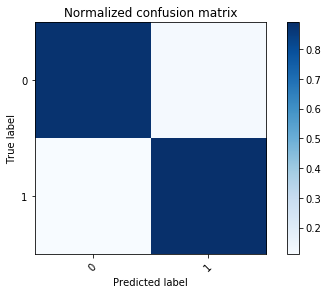

In [26]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test_sampled.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

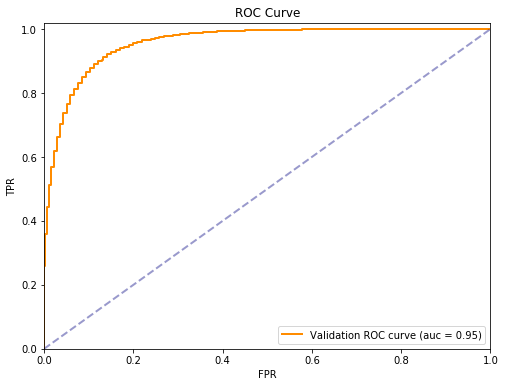

In [27]:
# ROC curve:______________________________________
validation_accuracy=model_lr.evaluate(test_sampled)
roc=validation_accuracy.roc.toPandas()
roc_auc=validation_accuracy.areaUnderROC

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(roc['FPR'],roc['TPR'], color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

# Algorithm 2:  Random Forest

In [29]:
# Undersmapling the majority class:
ratio = train.filter(train['label']==1).count() / train.filter(train['label']==0).count()

undersampled_train = train.sampleBy('label', fractions={0: ratio, 1: 1.0}, seed=42)

undersampled_train.groupby('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|418548|
|  1.0|417577|
+-----+------+



In [30]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',
                             maxDepth = 20,
                             numTrees = 20,
                             maxBins = 64)

# creating the Evaluator: 
from  pyspark.ml import evaluation 
evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

In [31]:
# fit the model:
model_rf = rf.fit(undersampled_train)

In [32]:
# Evaluation of RF model:
my_eval= evaluation.BinaryClassificationEvaluator(metricName='areaUnderROC')
print('Train roc_auc score: ', round(my_eval.evaluate(model_rf.transform(undersampled_train)),2))
print('Test roc_auc score: ', round(my_eval.evaluate(model_rf.transform(test)),2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Train f1 score: ', round(my_eval.evaluate(model_rf.transform(undersampled_train)),2))
print('Test f1 score: ', round(my_eval.evaluate(model_rf.transform(test)),2))

Train roc_auc score:  0.96
Test roc_auc score:  0.95 

Train f1 score:  0.89
Test f1 score:  0.89


In [33]:
# Prediction on test dataset:
test_sampled = test.sampleBy('label', fractions={0: 0.05, 1: 0.05}, seed=42)

test_predictions = model_rf.transform(test_sampled)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[18.4516308784378...|[0.92258154392189...|       0.0|
|  0.0|[14.5311255998170...|[0.72655627999085...|       0.0|
|  0.0|[15.5600800223947...|[0.77800400111973...|       0.0|
|  0.0|[8.56879322078727...|[0.42843966103936...|       1.0|
|  0.0|[12.6219269470429...|[0.63109634735214...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[121189  20163]
 [   765   8185]]
Normalized confusion matrix
[[0.86 0.14]
 [0.09 0.91]]


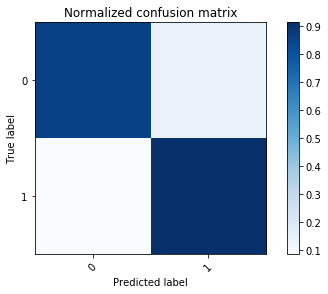

In [34]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test_sampled.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

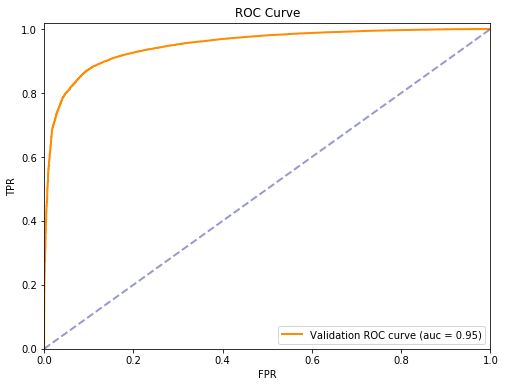

In [35]:
# ROC curve:______________________________________
results= test_predictions.select(['probability', 'label']).collect()
results = [(i[0][0], 1.0-i[1]) for i in results]

from sklearn.metrics import roc_curve, auc
 
fpr= dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results]
y_score = [i[0] for i in results]
 
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(fpr, tpr, color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")


plt.show()

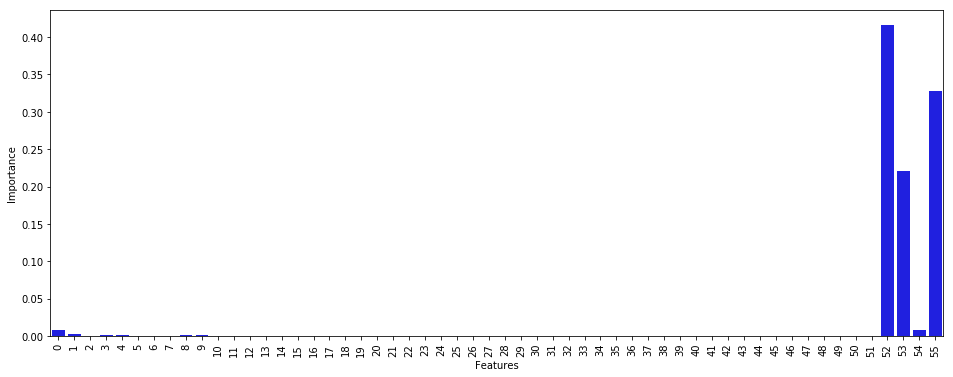

In [36]:
# Feature Importance: 
im=model_rf.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=90)
plt.show()

# Algorithm 3:  Gradient-Boosted Trees

In [37]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'features', labelCol = 'label',
                   maxDepth = 6, 
                   maxIter = 48,
                   maxBins = 64)

# creating the Evaluator: 
from  pyspark.ml import evaluation 
evaluator=evaluation.MulticlassClassificationEvaluator(metricName='f1')

In [38]:
# fit the model on train dataset with Undersampled majority class:
model_gb=gb.fit(undersampled_train)

In [39]:
# Evaluation of GBT model:
print("Train f1 score:  ", round(evaluator.evaluate(model_gb.transform(undersampled_train)),2))
print("Test f1 score:  ", round(evaluator.evaluate(model_gb.transform(test)),2))

Train f1 score:   0.89
Test f1 score:   0.9


In [40]:
# Prediction on test dataset:
test_predictions = model_gb.transform(test_sampled)
test_predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[122941  18411]
 [   835   8115]]
Normalized confusion matrix
[[0.87 0.13]
 [0.09 0.91]]


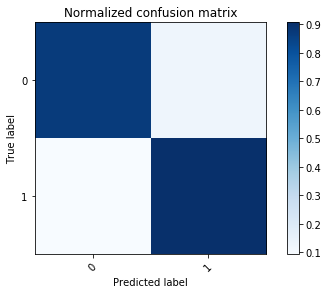

In [41]:
# Plot a confusion matrix:   
# Compute confusion matrix:
y_test=test_sampled.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

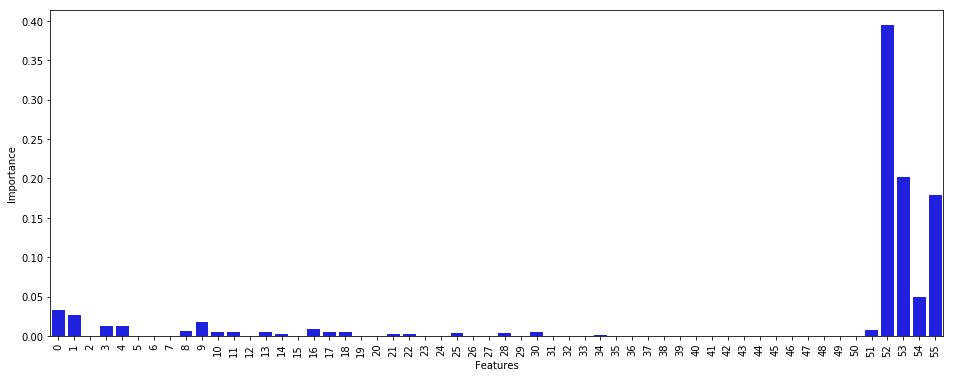

In [42]:
# Feature Importance: 
im=model_gb.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=90)

plt.show()

In [43]:
sc.stop()